In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from scipy.sparse.linalg import svds

from surprise import (SVD
                      , SVDpp
                      , NMF
                      , NormalPredictor
                      , BaselineOnly)
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection.validation import cross_validate
from surprise import accuracy

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from matplotlib import rcParams, cm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.models import (load_data
                        , data_summary
                        , combine_tables
                        , collab_mat
                        , svd_mat
                        , svd_model
                        , surprise_bench
                        , top_biz_pred
                        , NMF_Mat
                        , NN_Model
                        , NN_Results_df
                        , con_bas_biz_rec
                       )

### Load Data

In [4]:
biz_df, rev_df, ckin_df, pho_df, tip_df, user_df = load_data()

In [5]:
data_summary(biz_df
             , rev_df
             , ckin_df
             , pho_df
             , tip_df
             , user_df)

name,rows,colums
business,192609,14
review,6685900,9
checkin,161950,2
photo,200000,4
tip,1223094,5
user,1637138,22


In [6]:
user_rev_biz = combine_tables(user_df
                              , rev_df
                              , biz_df)

In [7]:
user_rev_biz.city.value_counts()[0:5]

Las Vegas     1757375
Phoenix        645716
Toronto        434349
Scottsdale     329826
Charlotte      273989
Name: city, dtype: int64

In [8]:
user_rev_biz_scott = user_rev_biz.loc[user_rev_biz.city == 'Scottsdale']
user_rev_biz_scott.shape

(329826, 36)

In [9]:
len(user_rev_biz_scott.user_id.unique())

140940

In [10]:
len(user_rev_biz_scott.business_id.unique())

7081

In [11]:
average_user_stars_given = pd.DataFrame(user_rev_biz_scott.average_stars.value_counts())

In [12]:
user_rev_biz_scott.average_stars.mean()

3.849698052912747

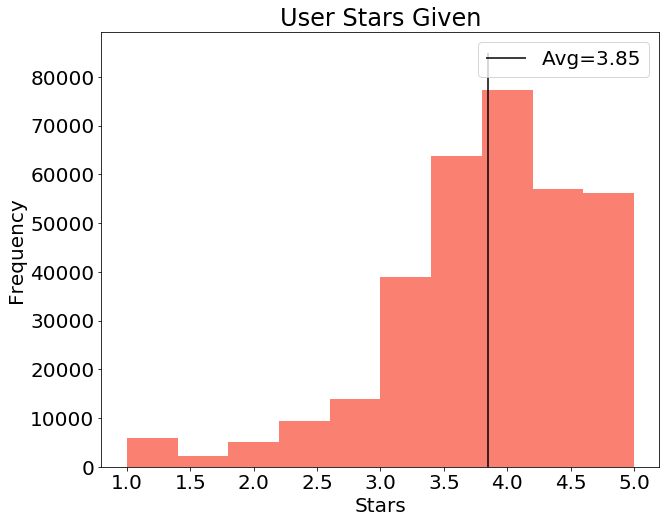

In [13]:
plt.figure(figsize=(10,8))

plt.hist(user_rev_biz_scott.average_stars, color='salmon')
plt.vlines(3.85, 0, 85000, label = 'Avg=3.85')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('User Stars Given')
plt.legend();
plt.savefig('png/user_stars_given.png')

In [14]:
biz_stars_df = pd.DataFrame(user_rev_biz_scott.biz_star.value_counts().sort_index())

In [15]:
user_rev_biz_scott.biz_star.mean()

3.9298751462892554

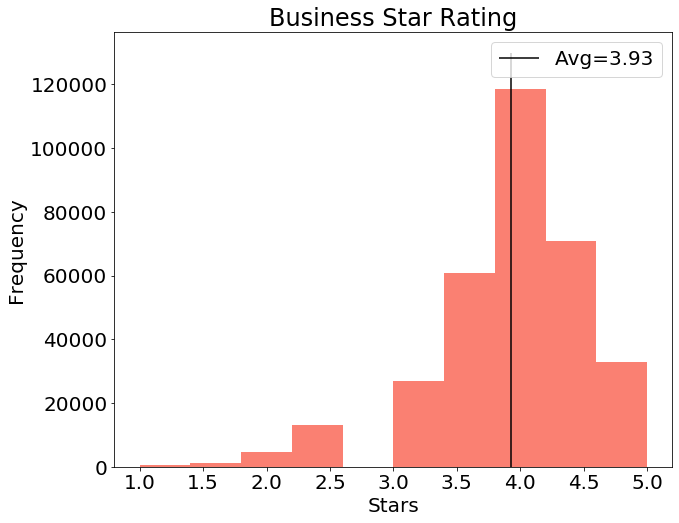

In [16]:
plt.figure(figsize=(10,8))
plt.hist(user_rev_biz_scott.biz_star, color='salmon')
plt.vlines(3.93, 0, 130000, label='Avg=3.93')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Business Star Rating')
plt.legend();
plt.savefig('png/biz_stars_rating.png')

In [17]:
user_rev_biz_scott.biz_review_count.median()

191.0

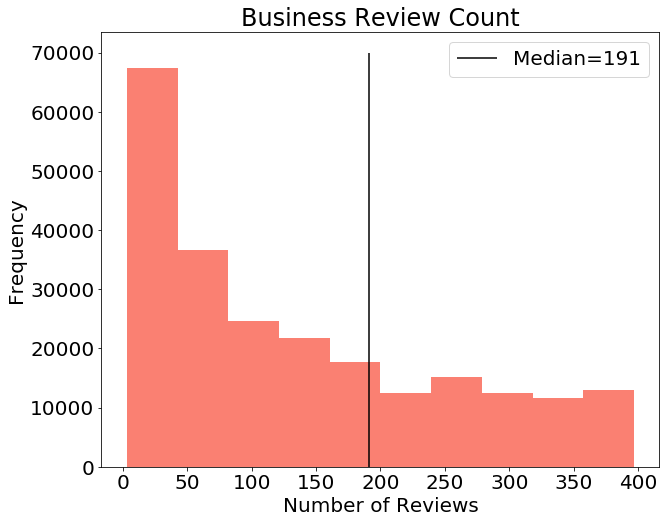

In [18]:
plt.figure(figsize=(10,8))
plt.hist(user_rev_biz_scott.biz_review_count.loc[user_rev_biz_scott.biz_review_count < 400], color='salmon')
plt.vlines(191, 0, 70000, label='Median=191')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Business Review Count')
plt.legend();
plt.savefig('png/biz_rev_count.png')

In [19]:
user_rev_biz_scott.user_review_count.median()

21.0

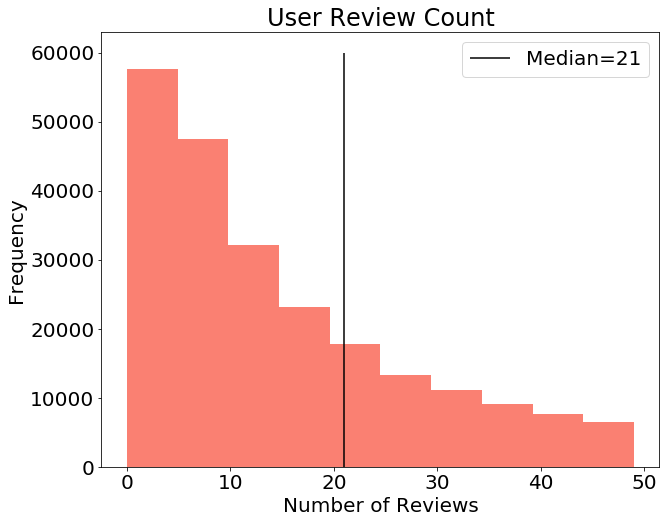

In [20]:
plt.figure(figsize=(10,8))
plt.hist(user_rev_biz_scott.user_review_count.loc[user_rev_biz_scott.user_review_count < 50], color='salmon')
plt.vlines(21, 0, 60000, label='Median=21')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('User Review Count')
plt.legend();
plt.savefig('png/user_rev_count.png')

In [21]:
n = 34
cat_short = []
for cat in user_rev_biz_scott.categories.value_counts()[0:n].index:
    cat_short.append(cat[:9])
cat_short = np.array(cat_short)
cat_short

array(['Mexican, ', 'Restauran', 'Nightlife', 'Latin Ame', 'American ',
       'Cocktail ', 'American ', 'Nightlife', 'Mexican, ', 'Sandwiche',
       'Restauran', 'Food, Mex', 'Brazilian', 'Restauran', 'Vegetaria',
       'Pizza, Re', 'Coffee & ', 'Nightlife', 'American ', 'American ',
       'Farmers M', 'Salad, Bu', 'Restauran', 'Food, Res', 'Event Pla',
       'American ', 'Steakhous', 'Sandwiche', 'Breakfast', 'Sandwiche',
       'Persian/I', 'American ', 'Restauran', 'Cafes, Am'], dtype='<U9')

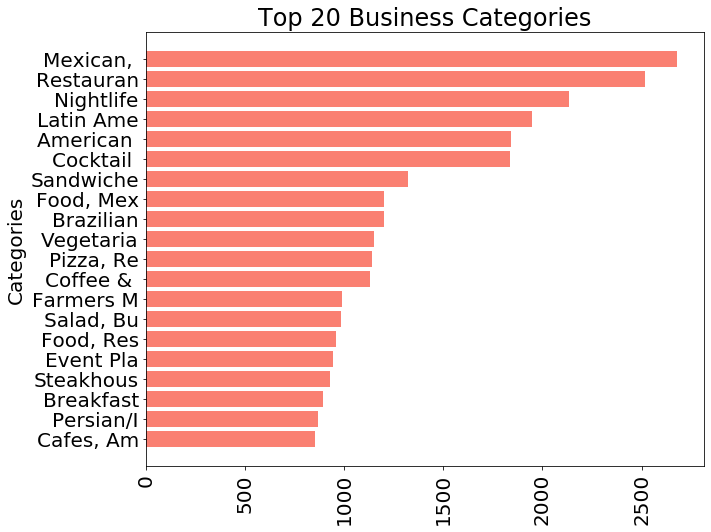

In [79]:
plt.figure(figsize=(10,8))

plt.barh(cat_short
       , user_rev_biz_scott.categories.value_counts()[0:n].values, color='salmon')
plt.xticks(rotation=90)
plt.ylabel('Categories')
plt.gca().invert_yaxis()
plt.title('Top 20 Business Categories');
plt.savefig('png/top_20_biz_cat.png')

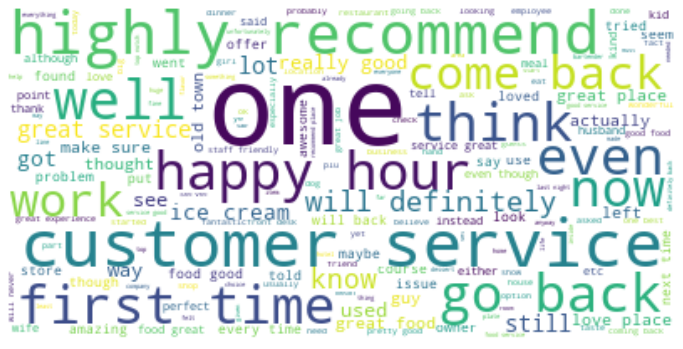

In [23]:
all_rev_words_scott = ' '.join(user_rev_biz_scott.rev_text.str.lower())

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200).generate(all_rev_words_scott)

# Display the wordcloud image:
plt.figure(figsize=[12,9])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show(); 
# plt.savefig('png/wordcloud_reviews.png');

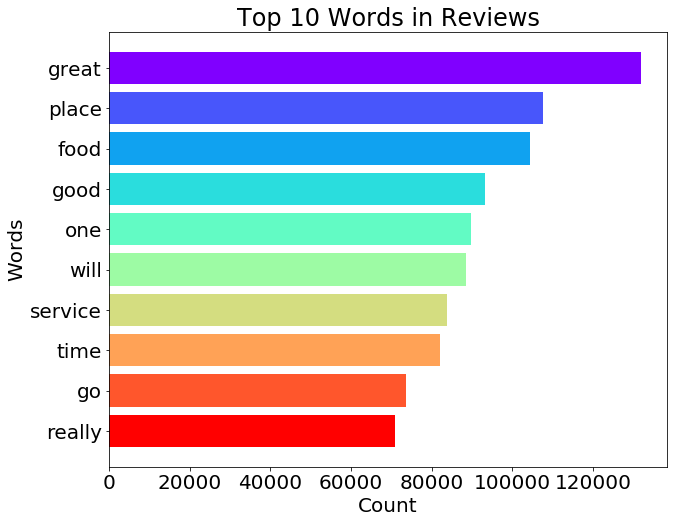

In [24]:
stopwords = STOPWORDS

filtered_words = [word for word in all_rev_words_scott.split() if word not in stopwords]
counted_words = Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=[10, 8])

plt.title('Top 10 Words in Reviews')
plt.xlabel('Count')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.barh(words, counts, color=colors);
plt.savefig('png/top_10_words_rev.png')

In [25]:
biz_id_scott = user_rev_biz_scott.business_id.unique()

In [26]:
biz_id_scott

array(['lV3qjLJF_5QujITWHZ64gg', 'p-8AMN9Q0qwym-3Pdle20Q',
       '-LRlx2j9_LB3evsRRcC9MA', ..., '5HPBIG3BVMIfy4_-D9zPIQ',
       'k-qjgxB45hV0627P6KRYJQ', 'a4PI8XlT_nXrH93vAo28UQ'], dtype=object)

In [27]:
len(biz_id_scott)

7081

In [28]:
tip_df.columns

Index(['user_id', 'business_id', 'text', 'date', 'compliment_count'], dtype='object')

In [29]:
tip_df.shape

(1223094, 5)

In [30]:
tip_df_scott = tip_df[tip_df.business_id.isin(biz_id_scott)]

In [31]:
tip_df_scott.shape

(51387, 5)

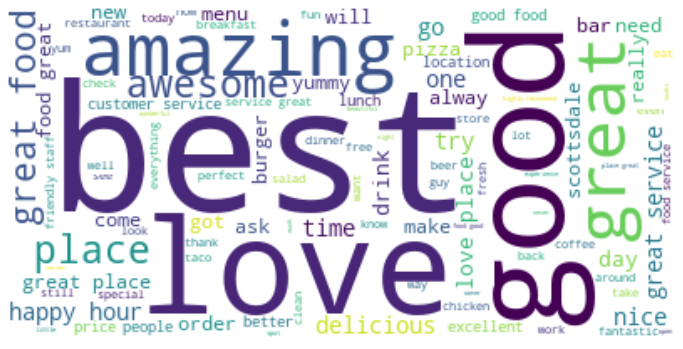

In [32]:
all_tip_words_scott = ' '.join(tip_df_scott.text.str.lower())

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=100).generate(all_tip_words_scott)

# Display the wordcloud image:
plt.figure(figsize=[12,9])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");
# plt.savefig('png/wordcloud_tips.png');

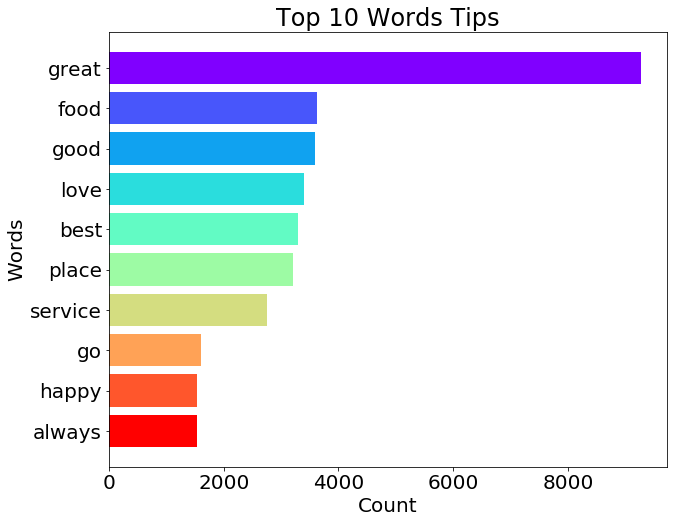

In [34]:
stopwords = STOPWORDS
stopwords.add('&')


filtered_words = [word for word in all_tip_words_scott.split() if word not in stopwords]
counted_words = Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=[10, 8])

plt.title('Top 10 Words Tips')
plt.xlabel('Count')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.barh(words, counts, color=colors);
plt.savefig('png/top_10_words_tip.png')

In [35]:
ckin_df.shape

(161950, 2)

In [36]:
ckin_df_scott = ckin_df[ckin_df.business_id.isin(biz_id_scott)]

In [37]:
ckin_df_scott.shape

(5638, 2)

In [38]:
ckin_df_scott.columns

Index(['business_id', 'date'], dtype='object')

In [39]:
ckin_df_scott['date'].iloc[0]

'2010-03-23 05:49:25, 2010-08-27 05:38:45, 2010-09-05 23:37:14, 2010-09-10 02:13:41, 2010-10-26 19:01:51, 2010-12-10 21:23:20, 2010-12-23 21:47:12, 2011-01-04 20:23:02, 2011-01-16 21:18:05, 2011-01-22 06:05:02, 2011-01-22 20:24:46, 2011-01-22 21:42:04, 2011-02-02 16:31:12, 2011-02-03 18:46:48, 2011-02-19 04:02:34, 2011-03-18 18:51:57, 2011-04-16 02:49:44, 2011-04-16 02:50:57, 2011-04-22 05:38:01, 2011-04-27 14:45:58, 2011-05-19 14:40:43, 2011-05-20 00:01:04, 2011-05-26 20:01:58, 2011-05-31 14:43:41, 2011-06-01 14:46:34, 2011-06-03 03:44:22, 2011-06-05 15:50:45, 2011-06-05 21:58:51, 2011-06-10 14:46:09, 2011-06-10 18:49:33, 2011-06-11 13:43:32, 2011-06-11 20:46:51, 2011-06-12 00:47:30, 2011-06-12 22:48:05, 2011-06-13 02:59:13, 2011-06-13 14:16:25, 2011-06-13 23:34:56, 2011-06-15 00:03:00, 2011-06-15 23:47:11, 2011-06-16 04:01:12, 2011-06-16 14:47:48, 2011-06-17 00:05:25, 2011-06-17 15:26:03, 2011-06-20 17:53:19, 2011-06-22 18:46:58, 2011-06-22 18:49:22, 2011-07-01 05:01:10, 2011-07-01 0

In [40]:
ckin_df_scott.head()

,business_id,date
45,-01XupAWZEXbdNbxNg5mEg,"2010-03-23 05:49:25, 2010-08-27 05:38:45, 2010..."
101,-1BPe8UjF2_l3nVk-DFUjA,"2015-12-03 18:44:00, 2016-03-17 18:19:21, 2016..."
151,-2TKoFglMQvSmHSNWf6S8Q,"2012-08-14 01:38:56, 2012-09-18 23:27:48, 2012..."
183,-37_L44VjFw1U4tBfBDHRw,"2015-01-21 18:10:30, 2015-02-14 01:31:49, 2015..."
216,-4-2NZvqC68eOCiwmCQTiQ,"2018-05-16 19:50:42, 2018-09-08 00:44:43"


In [41]:
ckin_df_scott['checkins'] = ckin_df_scott.date.str.split(', ').apply(len)

In [42]:
ckin_df_scott.head()

,business_id,date,checkins
45,-01XupAWZEXbdNbxNg5mEg,"2010-03-23 05:49:25, 2010-08-27 05:38:45, 2010...",307
101,-1BPe8UjF2_l3nVk-DFUjA,"2015-12-03 18:44:00, 2016-03-17 18:19:21, 2016...",3
151,-2TKoFglMQvSmHSNWf6S8Q,"2012-08-14 01:38:56, 2012-09-18 23:27:48, 2012...",6
183,-37_L44VjFw1U4tBfBDHRw,"2015-01-21 18:10:30, 2015-02-14 01:31:49, 2015...",8
216,-4-2NZvqC68eOCiwmCQTiQ,"2018-05-16 19:50:42, 2018-09-08 00:44:43",2


In [43]:
ckin_df_scott.checkins.value_counts()

1       572
2       365
3       284
4       247
5       153
       ... 
330       1
326       1
298       1
286       1
1999      1
Name: checkins, Length: 891, dtype: int64

In [44]:
ckin_df_scott.checkins.median()

21.0

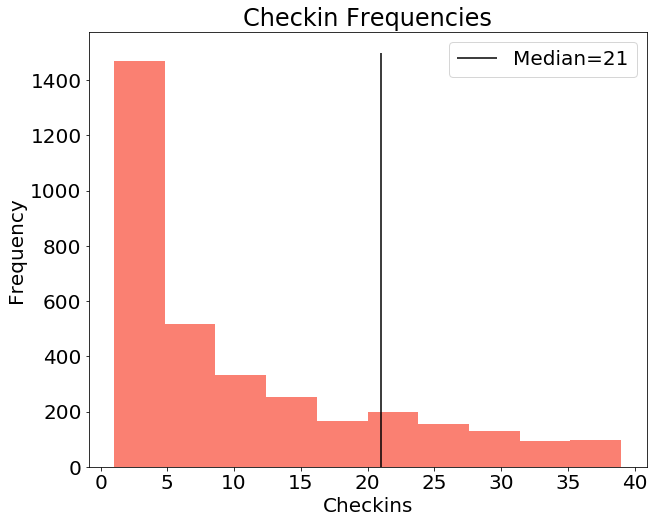

In [45]:
plt.figure(figsize=[10,8])
plt.hist(ckin_df_scott.checkins.loc[ckin_df_scott.checkins < 40], color = 'salmon')
plt.vlines(21, 0, 1500, label='Median=21')
plt.xlabel('Checkins')
plt.ylabel('Frequency')
plt.title('Checkin Frequencies')
plt.legend();
plt.savefig('png/checkin_frequencies.png')

### SVD

In [46]:
user_biz_collab_mat = collab_mat('Scottsdale'
                                 , user_rev_biz)

In [47]:
sigma, user_biz_predictions = svd_mat(user_biz_collab_mat, k=40)

### SVD Predictions

In [48]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = user_biz_predictions
             , n=10)

('Kristin',
 ['True Food Kitchen',
  'Cafe Monarch',
  'The Herb Box',
  'Sweet Republic',
  'Talking Stick Resort',
  'Roka Akor - Scottsdale',
  'Sprinkles Cupcakes',
  "Portillo's Hot Dogs",
  'iPic Theaters',
  'Studio Movie Grill'])

In [49]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:10]

3360        Butters Pancakes & Café
312378                   Wildflower
600627                 Flower Child
624904                 Viet Kitchen
744479                   Wildflower
746301     Original Breakfast House
771054      Andreoli Italian Grocer
838710                 Barrio Queen
1147492        Rocket Burger & Subs
1155989                 Rustic Cafe
Name: biz_name, dtype: object

### NMF

In [80]:
nmf_mat = NMF_Mat(user_biz_collab_mat)

### NMF Predictions

In [81]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = nmf_mat
             , n=10)

('Kristin',
 ['True Food Kitchen',
  'Hopdoddy Burger Bar',
  'The Thumb BBQ',
  'SOL Mexican Cocina',
  'Butters Pancakes & Café',
  "Coconut's Fish Cafe",
  'Salty Sow',
  'North Italia',
  "Portillo's Hot Dogs",
  'Sweet Republic'])

In [82]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:10]

3360        Butters Pancakes & Café
312378                   Wildflower
600627                 Flower Child
624904                 Viet Kitchen
744479                   Wildflower
746301     Original Breakfast House
771054      Andreoli Italian Grocer
838710                 Barrio Queen
1147492        Rocket Burger & Subs
1155989                 Rustic Cafe
Name: biz_name, dtype: object

### Validation

In [53]:
data, svd_acc, svd_cv = svd_model(df = user_rev_biz)

RMSE: 0.7053


In [54]:
svd_acc

0.7053259872438736

In [55]:
svd_cv

array([0.69881012, 0.69825966, 0.69762433, 0.70003275, 0.70411247])

In [56]:
NMF_results = cross_validate(NMF(), data, cv = 5)

In [57]:
NMF_results['test_rmse']

array([0.63674052, 0.63909498, 0.63846949, 0.64344959, 0.64374793])

In [83]:
bench_df = surprise_bench(df=user_rev_biz)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [84]:
bench_df

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.691716,0.478392,5.183528,0.273903
NMF,0.703249,0.536901,18.836889,0.318193
BaselineOnly,0.715314,0.506353,2.265070,0.415403
NormalPredictor,1.101105,0.865834,0.602831,0.524216


### Neural Network Predictor

In [60]:
# Source: https://www.youtube.com/watch?v=4vwNkHFuZBk

In [61]:
from tensorflow.keras.layers import (Input
                                     , Embedding
                                     , Dot
                                     , Flatten
                                    )
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import Callback

import os

In [62]:
user_id_dict, biz_id_dict, user_df, biz_df, X, X_test, model, history = NN_Model(df = user_rev_biz
                                                                                 , n_factors = 5
                                                                                 , ep = 16)


Testing loss: 14.215732196541525, acc: 0.0


Testing loss: 11.016947857249908, acc: 0.0002425506681902334


Testing loss: 9.039822286904716, acc: 0.0008367997943423688


Testing loss: 7.832813058654196, acc: 0.0012855185195803642


Testing loss: 7.072658583010964, acc: 0.001491686562076211


Testing loss: 6.580501443150768, acc: 0.0016008344246074557


Testing loss: 6.247477937817699, acc: 0.0016614720225334167


Testing loss: 6.021920852796915, acc: 0.0017221097368746996


Testing loss: 5.871197053861258, acc: 0.0017584923189133406


Testing loss: 5.771521270446433, acc: 0.0017584923189133406


Testing loss: 5.70017115825786, acc: 0.0017706198850646615


Testing loss: 5.6502944599676095, acc: 0.0017463647527620196


Testing loss: 5.614580312019187, acc: 0.0017827473348006606


Testing loss: 5.587820860856035, acc: 0.0017584923189133406


Testing loss: 5.569204995634976, acc: 0.0017827473348006606


Testing loss: 5.552724826945565, acc: 0.0017584923189133406

Instructions for updating

In [63]:
test_loss = [14.852330348244076
             , 11.795023531290191
             , 9.66295184869594
             , 8.333628240901511
             , 7.494445351904212
             , 6.955001253480135
             , 6.597846849382473
             , 6.354303274260258
             , 6.192977366455603
             , 6.08517013544577
             , 6.009048372511071
             , 5.9562121925898515
             , 5.917658338042835
             , 5.890479213768681
             , 5.869063134552363
             , 5.852976923782184
            ]

test_accuracy = [0.0
                 , 8.489273022860289e-05
                 , 0.0005457389634102583
                 , 0.0011036054929718375
                 , 0.0013582836836576462
                 , 0.001467431546188891
                 , 0.00147955899592489
                 , 0.0015765792923048139
                 , 0.0016372170066460967
                 , 0.0016008344246074557
                 , 0.0016735995886847377
                 , 0.0016008344246074557
                 , 0.0016857271548360586
                 , 0.0016129618743434548
                 , 0.0016614720225334167
                 , 0.0016129618743434548
                ]

In [64]:
print(len(test_loss))
print(len(test_accuracy))

16
16


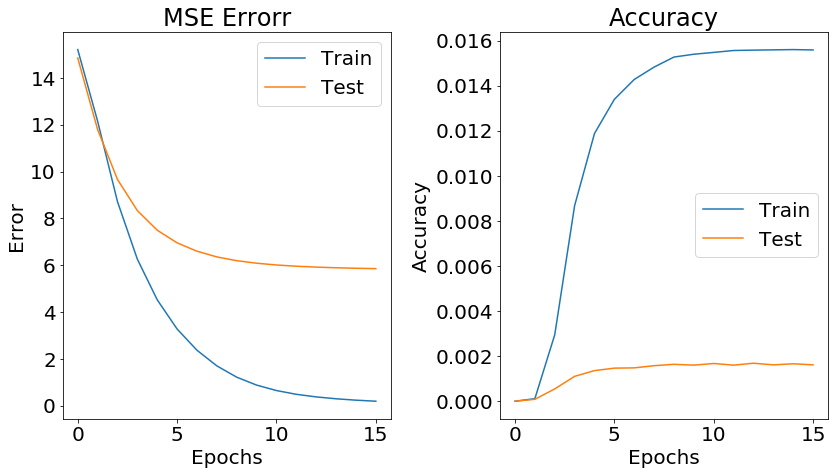

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12,7), tight_layout=True)
ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(test_loss, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error')
ax[0].set_title('MSE Errorr')
ax[0].legend()
    
ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(test_accuracy, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend();
plt.savefig('png/NN_loss_acc.png')

In [66]:
history.history['loss']

[15.21044437375878,
 12.153430226247506,
 8.71634051232558,
 6.257707968302118,
 4.521787300822472,
 3.2743631178097243,
 2.367708977470774,
 1.6993824719329238,
 1.2163087157461077,
 0.8784452035333228,
 0.6459329497209914,
 0.48475126230199955,
 0.3738020512231322,
 0.2937010148502995,
 0.23418832280949275,
 0.1897193768312467]

In [67]:
NN_Results_df(mod = model
             , xtest = X_test
             , n=15)

,user_name,biz_name,average_stars,Prediction
1600473,Mirco,Merci French Cafe & Patisserie,4.81,4.693114
773319,Scott,McCormick-Stillman Railroad Park,3.62,3.640141
2675092,Ashley,Zoes Kitchen,4.11,4.486089
3141992,Dawn,Scottsdale Nails,4.70,4.767819
2063207,Shaila,Saints & Scissors Salon,4.71,0.124253
3693030,Shaya,Persian Room,4.06,4.129117
6037906,Marnie,Sir Grout Phoenix,3.75,-0.059889
1878741,Chelsea,Houston's Restaurant,4.25,4.410995
4351605,Horace,Nekter Juice Bar,4.75,4.567302
4458509,Stephanie,Blue Adobe Santa Fe Grille,3.75,3.813275


In [68]:
user_id_dict

{'---PLwSf5gKdIoVnyRHgBA': 0,
 '--2HUmLkcNHZp0xw6AMBPg': 1,
 '--3B8LdT1NCD-bPkwS5-5g': 2,
 '--3WaS23LcIXtxyFULJHTA': 3,
 '--41c9Tl0C9OGewIR7Qyzg': 4,
 '--4rAAfZnEIAKJE80aIiYg': 5,
 '--5XzJ2pRsVVJiJUfzZlgQ': 6,
 '--CIuK7sUpaNzalLAlHJKA': 7,
 '--CJT4d-S8UhwqHe05QgfQ': 8,
 '--DxiDMQgN08E5gTM0aj7Q': 9,
 '--E_9aMNd1pgJFxe-oJ1OQ': 10,
 '--NceChXmZgyx57MtQFjyw': 11,
 '--Nnm_506G_p8MxAOQna5w': 12,
 '--PHyzUR6FEjHqxg9I60LA': 13,
 '--RY4bG7REOBum5HsSspxQ': 14,
 '--Rm-VyYWgHA7ZpljAMlvg': 15,
 '--ZB6p_MzwilQI0unCJVsQ': 16,
 '--_N9jPdYR9WdJKQhekANg': 17,
 '--bHHroMDGhmn9cIxKo9GQ': 18,
 '--bzLMRvwBo87e0Fb6ihUw': 19,
 '--eQVss9nAx54FWsZHZgpA': 20,
 '--egmQREiy-OJbJELjNwuA': 21,
 '--fF_pQlaU9sME-HLCoHlQ': 22,
 '--gBGXfVm5YyAVVkj84W5Q': 23,
 '--haaCngcz4NnX_IVSFswA': 24,
 '--iiD1TQzaXGxePZ1g5S2A': 25,
 '--kvGeSg0-nfm3pB9ED5Vw': 26,
 '--mQ4S5h1tXzvE9VDYVwdQ': 27,
 '--mSYQD4piZRagYS73frlQ': 28,
 '--nQ4-F7JINAlPir_f-VeQ': 29,
 '--oVdTxVd7QVr8Y0Ukz9uw': 30,
 '--qpuVw7_i9YB4Tlib1-9A': 31,
 '--rfv5EuomS0Rjkg

In [69]:
 biz_id_dict

{'-01XupAWZEXbdNbxNg5mEg': 0,
 '-1BPe8UjF2_l3nVk-DFUjA': 1,
 '-2TKoFglMQvSmHSNWf6S8Q': 2,
 '-37_L44VjFw1U4tBfBDHRw': 3,
 '-4-2NZvqC68eOCiwmCQTiQ': 4,
 '-4G-LJhOeTbAfQuaxCYeHA': 5,
 '-4TMQnQJW1yd6NqGRDvAeA': 6,
 '-4_n--u4Z_SBbgz1zUKpYw': 7,
 '-4dzsToZl39O95C5KWbJbg': 8,
 '-6h3K1hj0d4DRcZNUtHDuw': 9,
 '-6pjRBsLbkHyGcohvu_Jkw': 10,
 '-79cl_yASWXiv7RmzirNxA': 11,
 '-7ZjpebPJPYsAkOCDAZ-Sw': 12,
 '-8bGynxpc8t4-vhOy6FxTg': 13,
 '-9D4JHiKgd-1Eay-KbVpwA': 14,
 '-9ly39RQ8CvqxPuNZrGEbA': 15,
 '-9nai28tnoylwViuJVrYEQ': 16,
 '-AcyJ7-rjKPdEYJa-gplZg': 17,
 '-B0cfDL0_7PR1rLt0ThiQw': 18,
 '-B2WY_he81rS3Lnl0IWvPA': 19,
 '-BrMNg4MbpftOUTjOMVp9g': 20,
 '-CPD0t8h2Acd0r93779sKw': 21,
 '-CTmg9JYXWQkXnnW9uw8vA': 22,
 '-CdnZk0AULum7B_ThcZV-A': 23,
 '-DIZwl4igqddB_RQr_u3sg': 24,
 '-DgLrAuOKilHSeH8gFheEw': 25,
 '-FCUVf01SPTwVm5tCyu8Lw': 26,
 '-FLnsWAa4AGEW4NgE8Fqew': 27,
 '-GUi0xyzwT9KJPS0v96dRA': 28,
 '-GpsXedO2BOL0EGBe_bDuQ': 29,
 '-J1OaCKXduY9uHf8qGxYsA': 30,
 '-JFaysaI_sNmTarsl12jng': 31,
 '-L7W3egf0xOyT2oZ

In [70]:
X[X.user_num==1]

,user_num,user_name,biz_num,biz_name,average_stars
3360,1,Kristin,2252,Butters Pancakes & Café,4.6
312378,1,Kristin,3016,Wildflower,4.6
600627,1,Kristin,2928,Flower Child,4.6
771054,1,Kristin,462,Andreoli Italian Grocer,4.6
838710,1,Kristin,4476,Barrio Queen,4.6
1160456,1,Kristin,654,Grassroots Kitchen & Tap,4.6
1278832,1,Kristin,2105,La Fonda Del Sol,4.6
1296806,1,Kristin,6396,Diego Pops,4.6
1387807,1,Kristin,94,Jason's Deli,4.6
1679615,1,Kristin,2383,Zipps Sports Grill,4.6


In [71]:
predictions = model.predict([np.array([1 for _ in range(7081)])
                             , biz_df.index.values])

In [72]:
kristin_df = biz_df
kristin_df['user_name'] = 'Kristin'
kristin_df['user_num'] = 1
kristin_df['model_pred'] = predictions
kristin_df.head()

,business_id,biz_name,user_name,user_num,model_pred
0,-01XupAWZEXbdNbxNg5mEg,18 Degrees,Kristin,1,4.685809
1,-1BPe8UjF2_l3nVk-DFUjA,Journey Massage Therapy,Kristin,1,1.832599
2,-2TKoFglMQvSmHSNWf6S8Q,U.S. Bank,Kristin,1,4.450325
3,-37_L44VjFw1U4tBfBDHRw,Cloud Nine Wellness Spa,Kristin,1,0.480144
4,-4-2NZvqC68eOCiwmCQTiQ,Elle Nails,Kristin,1,2.600761


In [73]:
kristin_df.nlargest(28, ['model_pred'])

,business_id,biz_name,user_name,user_num,model_pred
1946,Fy1mU2z-06UsRgu88ELNOA,Old Town Ink,Kristin,1,6.893727
1463,Bfq78rBEJwE6QqOkRadldg,Sitter4Paws,Kristin,1,6.324358
4384,bYVr4qZanfPjJ6luXzLMdg,Precision Door Service,Kristin,1,6.285688
2787,Ntp-xe4x9mDAOEgpbNuPSA,Quick Mobile Repair,Kristin,1,6.070547
2699,N2FQ5a9KjbM2YmB1GbHXkg,Bob The Psychic,Kristin,1,5.835113
4634,dyJ3mIARCA2syArnqw4VPQ,Mark Mitsubishi Scottsdale,Kristin,1,5.757181
2370,Jsfko_bUBLRnpbetKRYISw,JW Auto Care,Kristin,1,5.717232
6175,rf9bz-K5iFTGFBLhJzW2zw,Dapper Dan's Barber Shop,Kristin,1,5.631784
3892,Y9fziLjGYFpMTHFXSe4e1w,AC by J,Kristin,1,5.607493
4922,g_A6WutN91EL__n61zj6Lg,TLC While You're Away,Kristin,1,5.459120


### Using Texts to Model Business to Business Similarity

In [74]:
con_bas_biz_rec(df = user_rev_biz, n = 5)

,name,rating
0,"Ferguson Bath, Kitchen & Lighting Gallery",0.516044
1,Scottsdale Rooter Plumbers,0.423362
2,Troon North Custom Tailor,0.421407
3,The Flower Cart,0.419961
4,Gainey Fabricare Cleaners,0.418511


In [75]:
user_rev_biz_scott.head()
    


,user_id,user_name,user_review_count,yelping_since,useful_user_sent,funny_user_sent,cool_user_sent,elite,friends,fans,...,funny_rev,cool_rev,rev_text,date,biz_name,city,biz_star,biz_review_count,attributes,categories
614,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,Bridesmaid dress was done on time. Price was o...,2013-04-17 03:14:53,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
615,O7ojHP59iSi32uhEDUR44A,Jasmine,696,2008-01-14 19:20:46,787,174,247,"2010,2011,2012,2013,2014,2015","UDURgNFjiLuN5KSYSkunPA, gZuY6f0HTxq2_zyww3196g...",27,...,0,0,"If I could Janet 7 stars, I would. I can't pra...",2012-10-24 16:41:09,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
616,HfmcMLJb3HMOen7VrLk0bw,Kim,29,2010-11-23 03:57:11,44,18,18,,"vHrc4qLZ_4B-PPkDZXvQAQ, CO-6Tlh2VEB7EzI-K3Ox6g...",2,...,0,0,I bought my dress from Luv Bridal and they had...,2015-10-21 05:53:04,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
617,BmipmKVTx37gpfPzK7eU4A,Kirstin,316,2009-05-29 15:59:11,809,369,325,"2010,2011,2012,2013","ApeyRs4SLCb2B01kiMf2qg, QMZhObocnRnQXHFok-4jWQ...",33,...,1,4,Janet was a god send for my wedding! We bought...,2011-06-20 23:14:50,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
618,_ILD1nTTCBjp0FdG1j2aNw,Colleen,10,2014-04-22 17:55:22,3,0,0,,"MgyZs6C9YxeIwGM8_od7wg, szNd9b4ide8OjqukU3k4Lg...",0,...,0,0,Janet is a master of her trade! She takes a pe...,2014-04-22 17:59:28,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."


In [76]:
urbs_cond = user_rev_biz_scott.drop_duplicates(subset = 'business_id')

In [77]:
urbs_cond[['business_id', 'biz_name']].iloc[0]

business_id    lV3qjLJF_5QujITWHZ64gg
biz_name                Janet Kirkman
Name: 614, dtype: object

In [78]:
urbs_cond.head()

,user_id,user_name,user_review_count,yelping_since,useful_user_sent,funny_user_sent,cool_user_sent,elite,friends,fans,...,funny_rev,cool_rev,rev_text,date,biz_name,city,biz_star,biz_review_count,attributes,categories
614,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,Bridesmaid dress was done on time. Price was o...,2013-04-17 03:14:53,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
637,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,This place would get 5 stars everytime if they...,2013-04-17 03:14:31,Pita Jungle,Scottsdale,4.0,467,"{'RestaurantsTakeOut': 'True', 'BikeParking': ...","Vegetarian, American (New), Middle Eastern, Me..."
1125,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,Thank you to the staff and Dr. Matchette for t...,2015-06-03 18:33:46,Kaibab Animal Hospital,Scottsdale,5.0,70,None,"Veterinarians, Pets"
1197,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,It's such a bummer that the service here is aw...,2013-11-11 18:21:08,Buffalo Wild Wings,Scottsdale,3.0,133,"{'CoatCheck': 'False', 'GoodForKids': 'True', ...","Sports Bars, Nightlife, Chicken Wings, Restaur..."
1340,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,1,0,0 stars for the crap oil change job and 1 star...,2013-02-25 21:06:56,Cobblestone Auto Spa,Scottsdale,2.5,308,{'BusinessAcceptsCreditCards': 'True'},"Automotive, Car Wash, Auto Detailing, Oil Chan..."
